In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### TIME AVERAGE MSD

Aim to plot time average mean squared deviation against tau

In [49]:

# CHAT GPT DEMONSTRATED A FEW ISSUES WITH THIS 

def time_average_msd(directory):

    taus = range(1, 100, 50) #3600 second long video

    def mean_square_distance(x1, y1, x0, y0):
        msd = (x1 - x0)**2 + (y1- y0)**2
        return msd 

    msd_results = []
    # taus = []

    for file in os.listdir(directory):

        if file.endswith("csv"):
            
            # join the directory and filename so you can read it

            file_path = os.path.join(directory, file)
            
            # read the csv file
            df = pd.read_csv(file_path)

            df = df.dropna(subset=['x_body', 'y_body'])

            if df.empty:
                print(f"Warning: {file} has no valid data after dropping NaNs.")
                continue


            # for every possible tau 
            # Loop Over Each Time Lag 𝜏

            msd_per_file = {'tau': [], 'msd': []}
            # tau_per_df = [] 
        
            for tau in taus:

                # think i need to iterate over each track for this one 
                # ask dan about this generating tracks too late on 

                track_msd_data = []

                for track in df['track_id'].unique():

                    track_unique = df[df['track_id'] == track].sort_values(by='frame')

                    # for i, row in track_unique.iterrows():
                    # Changed to range to avoid IndexError

                    for i in range(len(track_unique) - tau):

                        # if len(track_unique) <= tau:  # Skip if tau is larger than the number of unique tracks
        
                        #     continue

                        if len(track_unique) <= tau:
                            continue

                        # dont want to compare back to time 0. its in tau increments 
                         # we want position of i and i + tau 

                        # select columns and then use iloc for the specific row (integer based)

                        x1, y1 = track_unique[['x_body', 'y_body']].iloc[i + tau].values

                        x0, y0 = track_unique[['x_body', 'y_body']].iloc[i].values

                        track_msd = mean_square_distance(x1, y1, x0, y0)

                        track_msd_data.append(track_msd)

                # if track_msd_data:
                #     mean_msd_tau = np.mean(track_msd_data)
                #     msd_per_df.append(mean_msd_tau)
                # else:
                #     msd_per_df.append(np.nan)  # Placeholder for cases with no valid data
                
                mean_msd_tau = np.mean(track_msd_data)

                print(mean_msd_tau, track_msd_data)
                
                # msd_per_df.append(mean_msd_tau)
                  
                # # tau_per_df.append(tau)

                msd_per_file['tau'].append(tau)
                msd_per_file['msd'].append(mean_msd_tau)


            # once every tau and average track msd calculated per df      
            #

            msd_df = pd.DataFrame(msd_per_file)
            msd_df['file'] = file
            # all_data.append(msd_df)

            msd_results.append(msd_df)  
            # taus.append(tau_per_df)

    final_df = pd.concat(msd_results)
    final_df = final_df.pivot(index='tau', columns='file', values='msd').reset_index()
    return final_df


    # # shd obviously join these tgth i am not sure why i have done this lol 
    # return list(taus), msd_results



In [46]:
                if track_msd_data:
                    mean_msd_tau = np.mean(track_msd_data)
                    msd_per_df.append(mean_msd_tau)
                else:
                    msd_per_df.append(np.nan)  # Placeholder for cases with no valid data

NameError: name 'track_msd_data' is not defined

In [50]:
food_n1 = time_average_msd('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/N1/FOOD')

148.83618522414457 [0.6648492813110352, 120.93637487664819, 26.307992938905954, 168.94466039910913, 18.7799341827631, 69.02712205424905, 14.752483878284693, 36.230664886534214, 55.78069606795907, 460.3796967752278, 44.643184799700975, 18.853546608239412, 74.0933139398694, 71.24727914109826, 81.05818547680974, 61.447689443826675, 127.90339336544275, 157.47141315415502, 151.97263836860657, 141.47413026168942, 25.825631264597178, 141.7955192513764, 146.41257253661752, 257.24649297073483, 151.50735214352608, 182.41279197484255, 32.178292870521545, 143.095992077142, 229.85693365335464, 157.79117760900408, 160.76499989349395, 134.3068922534572, 154.20016426593202, 78.22377581149247, 78.09113245550638, 168.11909165699035, 169.75846870336682, 352.5867652045563, 84.03411373961717, 149.52137172967196, 132.31662893667817, 156.2625279398635, 280.0397000052035, 147.27447633165866, 103.83497709501424, 135.7714274525668, 16.750713743268996, 584.4686923036352, 102.10131258983165, 128.14115158096, 286.

In [51]:
food_n1

file,tau,2024-06-28_11-23-29_td4.tracks.csv,2024-06-28_11-24-05_td5.tracks.csv,2024-06-28_15-28-14_td1.tracks.csv,2024-06-28_15-28-16_td2.tracks.csv,2024-07-01_11-33-59_td1.tracks.csv,2024-07-01_11-34-04_td2.tracks.csv,2024-07-01_12-36-22_td1.tracks.csv,2024-07-01_12-36-23_td2.tracks.csv
0,1,95.095980,208.956017,189.120879,141.946040,148.836185,209.721611,100.767201,184.178863
1,51,37178.371202,165939.630019,142866.502211,91775.175645,75669.952090,252071.916045,71482.182263,163136.905581


In [52]:
# why are there nan values
# how do i plot this whatsoever 
# i dont want any file names



,file,value
0,tau,1.000000
1,tau,51.000000
2,2024-06-28_11-23-29_td4.tracks.csv,95.095980
3,2024-06-28_11-23-29_td4.tracks.csv,37178.371202
4,2024-06-28_11-24-05_td5.tracks.csv,208.956017
5,2024-06-28_11-24-05_td5.tracks.csv,165939.630019
6,2024-06-28_15-28-14_td1.tracks.csv,189.120879
7,2024-06-28_15-28-14_td1.tracks.csv,142866.502211
8,2024-06-28_15-28-16_td2.tracks.csv,141.946040
9,2024-06-28_15-28-16_td2.tracks.csv,91775.175645


/var/folders/g_/qk19_b9s62l1w5lmx5_1gmzjx_y855/T/ipykernel_3184/510265007.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)
/var/folders/g_/qk19_b9s62l1w5lmx5_1gmzjx_y855/T/ipykernel_3184/510265007.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)
/var/folders/g_/qk19_b9s62l1w5lmx5_1gmzjx_y855/T/ipykernel_3184/510265007.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)


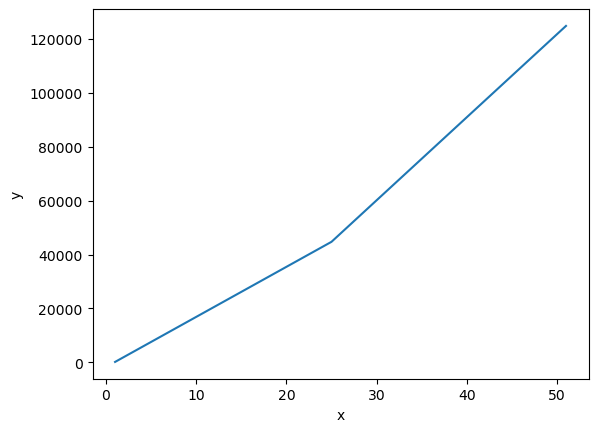

In [71]:
def load_data(dir):
    dfs = []
    for file in os.listdir(dir):
        if file.endswith("csv"):
            path = os.path.join(dir, file)
            df   = pd.read_csv(path)
            df["file"] = file

            dfs.append(df)

    df = pd.concat(dfs)
    df = df[["file", "track_id", "frame", "x_body", "y_body"]]

    return df

def calculate_x2(df, tau):
    # a. append lagged data
    df = df.sort_values(by = ["file", "track_id", "frame"])
    df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)

    # b. calculate msd for each frames
    df["msd"] = (df["x_body"] - df["x_body_lagged"]) ** 2 + (df["y_body"] - df["y_body_lagged"]) ** 2

    # c. aggregate to avg by frame
    df = df[df["msd"].notnull()] 
    df = df.groupby(["frame"])["msd"].mean()

    # d. take avg of avg across frames
    x2 = df.sum() / len(df)
    return x2

def plot_x2s(dir, taus):
    df = load_data(dir)

    x2s = []
    for tau in taus:
        x2 = calculate_x2(df, tau)
        x2s.append(x2)

    sns.lineplot({"x":taus, "y":x2s}, x = "x", y = "y")

plot_x2s('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/N1/FOOD', [1, 25, 51])

### TIME AVERAGE MSD

-> concat all files 

-> calculate average msd for each frame 

-> for each tau calculate the average of all the msd's


In [99]:
# JOIN ALL FILES 

def concat(directory):
    
    dfs = []

    for file in os.listdir(directory):
        # print(file)
            
        if file.endswith("csv"):

            file_path = os.path.join(directory, file) # join path and file
        
            df = pd.read_csv(file_path) # read the csv file

            df = df.dropna(subset=['x_body', 'y_body']) # drop rows without body parts 

            if df.empty:
                print(f"Warning: {file} has no valid data after dropping NaNs.")
                continue

            df["file"] = file # column with file name 

            dfs.append(df)

    df = pd.concat(dfs).reset_index()
    df = df[["file", "track_id", "frame", "x_body", "y_body"]] # chose specific parts of the dataframe

    # sort the df by a) file b) unique track c) frame each track present for 
    df = df.sort_values(by = ["file", "track_id", "frame"]) 

    return df 


# CALCULATE MEAN SQUARED DISPLACAMENT (Ttau - T0) FOR EACH TRACK 

# WANT TO RETURN ONE NUMBER PER TAU 

def msd_per_tau(df, tau): # simply imagine this is a single tau for now 

    # df sorted by file, track and frame
    # loop through every track 

    # count number of vIABLE tracks 
    viable_tracks = 0
    
    msd = []

    for track in df['track_id'].unique():
        # print(track)

        track_unique = df[df['track_id'] == track]

        if len(track_unique) <= tau:
            continue 

        viable_tracks += 1
        
        initial_x, initial_y = track_unique.iloc[0][['x_body', 'y_body']] # when sleap better originate from 0 for each track 
        # print(initial_x)

        tau_x, tau_y = track_unique.iloc[tau][['x_body', 'y_body']]
        # print(tau_x)

        mean_square_displacement = (tau_x - initial_x) ** 2 + (tau_y - initial_y) ** 2 

        msd.append(mean_square_displacement)
    
    return sum(msd) / viable_tracks


def time_average_msd(directory, taus):

    df = concat(directory)

    msds = []

    for tau in taus:

        msd = msd_per_tau(df, tau)

        msds.append(msd)
    
    tau_msd_df = pd.DataFrame({'tau': taus, 'msd': msds})

    
    return tau_msd_df



In [100]:
# try with very short directory = works 
# put in print statments such that i do trust its working :)

agarose_n10 = time_average_msd('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/agarose-2', list(range(1, 101, 1)))

agarose_n10

,tau,msd
0,1,114142.432918
1,2,168770.565420
2,3,172287.696170
3,4,182771.075472
4,5,201210.194250
...,...,...
95,96,364106.100846
96,97,365885.257406
97,98,362299.900865
98,99,363444.818094


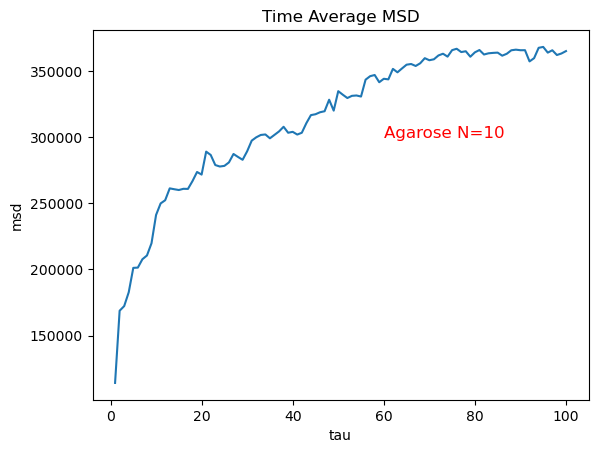

In [111]:
sns.lineplot(data=agarose_n10, x='tau', y='msd')

plt.title('Time Average MSD')

plt.text(60, 300000, 'Agarose N=10', fontsize=12, color='red')

plt.show()

In [106]:
food_n10 = time_average_msd('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/food-2', list(range(1, 101, 1)))

food_n10

,tau,msd
0,1,33828.389985
1,2,34604.261289
2,3,33175.394121
3,4,56140.203414
4,5,57060.985637
...,...,...
95,96,274249.002379
96,97,266865.868653
97,98,267580.766765
98,99,265578.518214


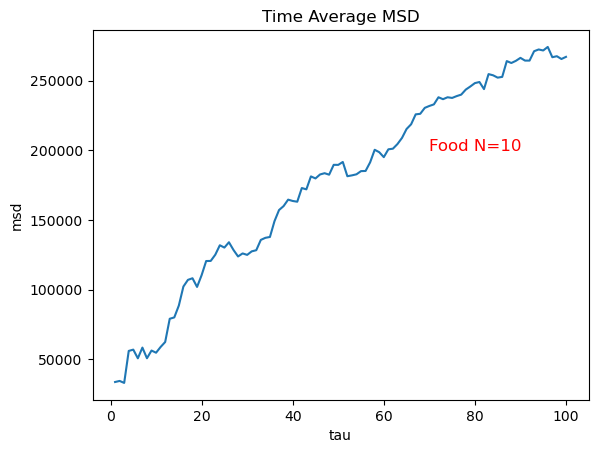

In [115]:
sns.lineplot(data=food_n10, x='tau', y='msd')

plt.title('Time Average MSD')

plt.text(70, 200000, 'Food N=10', fontsize=12, color='red')

plt.show()